RUN KNN WITH BCE BCE

# Import GitHub repository

In [1]:
import os
import logging
import sys

In [2]:
import torch
torch.cuda.is_available()

True

In [3]:
if not os.path.isdir('./owr'):
  !git clone -b icarl https://github.com/gianluigilopardo/Open-World-Recognition.git
  !mv 'Open-World-Recognition' 'owr'

# Import packages

In [4]:
from owr import ResNet
from owr.dataset import Subset
from owr.icarl import classify
from owr.icarl import incremental_train
from owr.icarl import update_representation
from owr.icarl import construct_exemplar_set
from owr.icarl import reduce_exemplars
from owr.icarl import generate_new_exemplars
from owr.models import compute_loss
from owr.models import train_network
from owr import params
from owr import utils
from owr.utils import get_classes_names
from owr.utils import get_task_indexes
from owr.utils import splitter
from owr.utils import map_splits
from owr.utils import get_classes
from owr.utils import get_indexes
import owr.models

In [5]:
from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import random

In [6]:
pip install seaborn

In [7]:
print(params.SEED)
print(params.NUM_WORKERS)

42
2


# Define Datasets

In [8]:
train_transformer = transforms.Compose([transforms.RandomCrop(size = 32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transformer = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [9]:
from torchvision import datasets
trainDS = datasets.cifar.CIFAR100( 'data', train=True, download=True, transform=train_transformer)
testDS = datasets.cifar.CIFAR100( 'data', train=False, download=True, transform=test_transformer)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
splits = splitter()

# Define Network

In [11]:
ICaRL = ResNet.resnet32(num_classes=100)
ICaRL =  ICaRL.to(params.DEVICE)

In [12]:
exemplars = [None]*params.NUM_CLASSES

test_indexes =  []
accs_train = []
accs_test = []
classifier = 'nme'

In [13]:
classifier = KNeighborsClassifier()
clf_params = {'n_neighbors' : np.arange(1,19,2)}

In [14]:
def tmp_classify(images, exemplars, model, task, train_dataset, mean=None, classifier='nme', clf_params=None):
    if classifier == 'nme':
        preds, mean = classify_nme(images, exemplars, model, task, train_dataset, mean)
        return preds, mean
    else:
        preds, mean = classify_models(images, exemplars, model, task, train_dataset, mean, classifier, clf_params)
        return preds, mean

def classify_models(images, exemplars, model, task, train_dataset, cv, classifier, clf_params):
    splits = utils.splitter()
    model.train(False)
    m = torch.nn.Softmax(dim=1)
    with torch.no_grad():
        images = images.float().to(params.DEVICE)
        x_test = model(images)
        x_test = m(x_test)
    if cv == None:
        analyzed_classes = []
        for i in range(int(task / params.TASK_SIZE)+1):
            analyzed_classes = np.concatenate((analyzed_classes, splits[i]))
        l = []
        for k in range(len(analyzed_classes)):
            class_k = int(analyzed_classes[k])
            l.extend(exemplars[class_k])

        transformer = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        subset = Subset(train_dataset, l, transformer)
        data_loader = DataLoader(subset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE)
        df = pd.DataFrame(columns = ['data', 'labels'])
        for images, labels, idxs in data_loader:
            with torch.no_grad():
                images = images.float().to(params.DEVICE)
                x = model(images)
                x = m(x)
                tmp = pd.DataFrame()
                tmp['data'] = x.to('cpu')
                tmp['labels'] = labels.to('cpu')
                df = df.append(tmp)
        cv = GridSearchCV(classifier, clf_params)
        cv.fit(list(df['data']),list(df['labels']) )
        print(cv.best_params_)
    preds = cv.predict(x_test.to('cpu'))
    return torch.tensor(preds), cv

In [15]:
for task in range(0, params.NUM_TASKS*params.TASK_SIZE, params.TASK_SIZE):
    train_indexes = get_task_indexes(trainDS, task)
    test_indexes = test_indexes + get_task_indexes(testDS, task)

    train_dataset = Subset(trainDS, train_indexes, transform = train_transformer)
    test_dataset = Subset(testDS, test_indexes, transform = test_transformer)

    train_loader = DataLoader( train_dataset, num_workers=2, batch_size=params.BATCH_SIZE, shuffle=True)
    test_loader = DataLoader( test_dataset, num_workers=2, batch_size=params.BATCH_SIZE , shuffle=True )
    print(task)
    ICaRL, exemplars = incremental_train(trainDS, ICaRL, exemplars, task, train_transformer, loss_version='opt1')
    col = []
    for i,x in enumerate( splits[ :int(task/10) + 1]) : 
        v = np.array(x)
        col = np.concatenate( (col,v), axis = None)
        col = col.astype(int)
    mean = None
    total = 0.0
    running_corrects = 0.0
    
    for img, lbl, _ in train_loader:
        img = img.float().to(params.DEVICE)
        preds, mean = tmp_classify(img, exemplars, ICaRL, task, trainDS, mean, classifier, clf_params)
        preds = preds.to(params.DEVICE)
        if classifier == 'nme':
            labels = map_splits(lbl, col).to(params.DEVICE)
        else:
            labels = lbl.to(params.DEVICE)
        total += len(lbl)
        running_corrects += torch.sum(preds == labels.data).data.item()

    accuracy = float(running_corrects/total)
    print(f'task: {task}', f'train accuracy = {accuracy}')
    accs_train.append(accuracy)

    total = 0.0
    running_corrects = 0.0
    tot_preds = []
    tot_lab = []
    for img, lbl, _ in test_loader:
        img = img.float().to(params.DEVICE)
        preds, _ = tmp_classify(img, exemplars, ICaRL, task, trainDS, mean, classifier, clf_params)
        preds = preds.to(params.DEVICE)
        if classifier == 'nme':
            labels = map_splits(lbl, col).to(params.DEVICE)
        else:
            labels = lbl.to(params.DEVICE)
        tot_preds = np.concatenate( ( tot_preds, preds.data.cpu().numpy() ) )
        tot_lab = np.concatenate( (tot_lab, labels.data.cpu().numpy()  ) )
        total += len(lbl)
        running_corrects += torch.sum(preds == labels.data).data.item()

    accuracy = float(running_corrects/total)
    print(f'task: {task}', f'test accuracy = {accuracy}')
    accs_test.append(accuracy)

0
Step: 0, Epoch: 0, Loss: 0.03431284800171852, Accuracy: 0.1932
Step: 0, Epoch: 1, Loss: 0.020580248907208443, Accuracy: 0.4112
Step: 0, Epoch: 2, Loss: 0.022878309711813927, Accuracy: 0.4986
Step: 0, Epoch: 3, Loss: 0.02522558718919754, Accuracy: 0.5448
Step: 0, Epoch: 4, Loss: 0.02785695716738701, Accuracy: 0.5808
Step: 0, Epoch: 5, Loss: 0.012539481744170189, Accuracy: 0.602
Step: 0, Epoch: 6, Loss: 0.013883430510759354, Accuracy: 0.6284
Step: 0, Epoch: 7, Loss: 0.016325512900948524, Accuracy: 0.6728
Step: 0, Epoch: 8, Loss: 0.018430085852742195, Accuracy: 0.6632
Step: 0, Epoch: 9, Loss: 0.01624341867864132, Accuracy: 0.6854
Step: 0, Epoch: 10, Loss: 0.017453674226999283, Accuracy: 0.6996
Step: 0, Epoch: 11, Loss: 0.019068263471126556, Accuracy: 0.7142
Step: 0, Epoch: 12, Loss: 0.014780747704207897, Accuracy: 0.7308
Step: 0, Epoch: 13, Loss: 0.009104738011956215, Accuracy: 0.7368
Step: 0, Epoch: 14, Loss: 0.00784625206142664, Accuracy: 0.7608
Step: 0, Epoch: 15, Loss: 0.01631999015

/content/owr/icarl.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0).float()


udpate representation:  375 reduce exemplars: 0 costruct exemplars: 29
{'n_neighbors': 15}
task: 0 train accuracy = 0.975
task: 0 test accuracy = 0.872
10
Step: 10, Epoch: 0, Loss: 0.032751936465501785, Accuracy: 0.2845714285714286
Step: 10, Epoch: 1, Loss: 0.030763747170567513, Accuracy: 0.33814285714285713
Step: 10, Epoch: 2, Loss: 0.025517834350466728, Accuracy: 0.39285714285714285
Step: 10, Epoch: 3, Loss: 0.023691989481449127, Accuracy: 0.45071428571428573
Step: 10, Epoch: 4, Loss: 0.02470260299742222, Accuracy: 0.48642857142857143
Step: 10, Epoch: 5, Loss: 0.026802418753504753, Accuracy: 0.5147142857142857
Step: 10, Epoch: 6, Loss: 0.025226926431059837, Accuracy: 0.5425714285714286
Step: 10, Epoch: 7, Loss: 0.025221018120646477, Accuracy: 0.5587142857142857
Step: 10, Epoch: 8, Loss: 0.023517640307545662, Accuracy: 0.58
Step: 10, Epoch: 9, Loss: 0.021366577595472336, Accuracy: 0.5971428571428572
Step: 10, Epoch: 10, Loss: 0.021298861131072044, Accuracy: 0.6107142857142858
Step: 10

/content/owr/icarl.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0).float()


udpate representation:  703 reduce exemplars: 0 costruct exemplars: 29
{'n_neighbors': 5}
task: 10 train accuracy = 0.9384
task: 10 test accuracy = 0.7455
20
Step: 20, Epoch: 0, Loss: 0.041063014417886734, Accuracy: 0.25285714285714284
Step: 20, Epoch: 1, Loss: 0.041495587676763535, Accuracy: 0.3107142857142857
Step: 20, Epoch: 2, Loss: 0.03628894314169884, Accuracy: 0.3452857142857143
Step: 20, Epoch: 3, Loss: 0.03188394010066986, Accuracy: 0.37385714285714283
Step: 20, Epoch: 4, Loss: 0.03488212078809738, Accuracy: 0.4014285714285714
Step: 20, Epoch: 5, Loss: 0.032719437032938004, Accuracy: 0.42957142857142855
Step: 20, Epoch: 6, Loss: 0.03004724718630314, Accuracy: 0.4501428571428571
Step: 20, Epoch: 7, Loss: 0.037194568663835526, Accuracy: 0.4697142857142857
Step: 20, Epoch: 8, Loss: 0.03188354894518852, Accuracy: 0.5014285714285714
Step: 20, Epoch: 9, Loss: 0.03176271542906761, Accuracy: 0.5054285714285714
Step: 20, Epoch: 10, Loss: 0.03349728509783745, Accuracy: 0.530428571428571

/content/owr/icarl.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0).float()


udpate representation:  803 reduce exemplars: 0 costruct exemplars: 29
{'n_neighbors': 5}
task: 20 train accuracy = 0.9078
task: 20 test accuracy = 0.659
30
Step: 30, Epoch: 0, Loss: 0.05218854546546936, Accuracy: 0.26462196861626247
Step: 30, Epoch: 1, Loss: 0.04596736282110214, Accuracy: 0.3630527817403709
Step: 30, Epoch: 2, Loss: 0.04212731122970581, Accuracy: 0.42510699001426533
Step: 30, Epoch: 3, Loss: 0.04563288390636444, Accuracy: 0.47218259629101283
Step: 30, Epoch: 4, Loss: 0.04719185456633568, Accuracy: 0.5007132667617689
Step: 30, Epoch: 5, Loss: 0.04235050082206726, Accuracy: 0.530527817403709
Step: 30, Epoch: 6, Loss: 0.03933132067322731, Accuracy: 0.5452211126961484
Step: 30, Epoch: 7, Loss: 0.04394487291574478, Accuracy: 0.5657631954350927
Step: 30, Epoch: 8, Loss: 0.04234541580080986, Accuracy: 0.581169757489301
Step: 30, Epoch: 9, Loss: 0.04079395905137062, Accuracy: 0.5957203994293866
Step: 30, Epoch: 10, Loss: 0.03619350492954254, Accuracy: 0.6017118402282453
Step:

/content/owr/icarl.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0).float()


udpate representation:  904 reduce exemplars: 0 costruct exemplars: 29
{'n_neighbors': 1}
task: 30 train accuracy = 0.9486
task: 30 test accuracy = 0.60325
40
Step: 40, Epoch: 0, Loss: 0.06160735338926315, Accuracy: 0.26171428571428573
Step: 40, Epoch: 1, Loss: 0.05303862690925598, Accuracy: 0.3605714285714286
Step: 40, Epoch: 2, Loss: 0.05555146560072899, Accuracy: 0.41814285714285715
Step: 40, Epoch: 3, Loss: 0.054638173431158066, Accuracy: 0.45042857142857146
Step: 40, Epoch: 4, Loss: 0.05610162392258644, Accuracy: 0.4784285714285714
Step: 40, Epoch: 5, Loss: 0.051439229398965836, Accuracy: 0.501
Step: 40, Epoch: 6, Loss: 0.05165413022041321, Accuracy: 0.5214285714285715
Step: 40, Epoch: 7, Loss: 0.05587262287735939, Accuracy: 0.5357142857142857
Step: 40, Epoch: 8, Loss: 0.05361587554216385, Accuracy: 0.5597142857142857
Step: 40, Epoch: 9, Loss: 0.055697131901979446, Accuracy: 0.5754285714285714
Step: 40, Epoch: 10, Loss: 0.055236294865608215, Accuracy: 0.5801428571428572
Step: 40, 

/content/owr/icarl.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0).float()


udpate representation:  1003 reduce exemplars: 0 costruct exemplars: 28
{'n_neighbors': 3}
task: 40 train accuracy = 0.9238
task: 40 test accuracy = 0.5602
50
Step: 50, Epoch: 0, Loss: 0.06759718805551529, Accuracy: 0.26157142857142857
Step: 50, Epoch: 1, Loss: 0.07434815913438797, Accuracy: 0.3485714285714286
Step: 50, Epoch: 2, Loss: 0.06467796862125397, Accuracy: 0.4064285714285714
Step: 50, Epoch: 3, Loss: 0.06771320849657059, Accuracy: 0.455
Step: 50, Epoch: 4, Loss: 0.07008006423711777, Accuracy: 0.48428571428571426
Step: 50, Epoch: 5, Loss: 0.06078577786684036, Accuracy: 0.509
Step: 50, Epoch: 6, Loss: 0.062276605516672134, Accuracy: 0.5385714285714286
Step: 50, Epoch: 7, Loss: 0.06572281569242477, Accuracy: 0.5482857142857143
Step: 50, Epoch: 8, Loss: 0.06272268295288086, Accuracy: 0.5684285714285714
Step: 50, Epoch: 9, Loss: 0.06666412949562073, Accuracy: 0.5848571428571429
Step: 50, Epoch: 10, Loss: 0.06286884099245071, Accuracy: 0.6025714285714285
Step: 50, Epoch: 11, Loss: 

/content/owr/icarl.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0).float()


udpate representation:  1101 reduce exemplars: 0 costruct exemplars: 28
{'n_neighbors': 3}
task: 50 train accuracy = 0.9354
task: 50 test accuracy = 0.5295
60
Step: 60, Epoch: 0, Loss: 0.07569920271635056, Accuracy: 0.2353868194842407
Step: 60, Epoch: 1, Loss: 0.07839856296777725, Accuracy: 0.30401146131805157
Step: 60, Epoch: 2, Loss: 0.08278987556695938, Accuracy: 0.3683381088825215
Step: 60, Epoch: 3, Loss: 0.08187934011220932, Accuracy: 0.40673352435530086
Step: 60, Epoch: 4, Loss: 0.07417315244674683, Accuracy: 0.4444126074498567
Step: 60, Epoch: 5, Loss: 0.0708957239985466, Accuracy: 0.4863896848137536
Step: 60, Epoch: 6, Loss: 0.07543853670358658, Accuracy: 0.49727793696275074
Step: 60, Epoch: 7, Loss: 0.07622351497411728, Accuracy: 0.5194842406876791
Step: 60, Epoch: 8, Loss: 0.07200334966182709, Accuracy: 0.5376790830945559
Step: 60, Epoch: 9, Loss: 0.07688701897859573, Accuracy: 0.5588825214899713
Step: 60, Epoch: 10, Loss: 0.07905955612659454, Accuracy: 0.5797994269340975
St

/content/owr/icarl.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0).float()


udpate representation:  1198 reduce exemplars: 0 costruct exemplars: 28
{'n_neighbors': 5}
task: 60 train accuracy = 0.932
task: 60 test accuracy = 0.4828571428571429
70
Step: 70, Epoch: 0, Loss: 0.09155017137527466, Accuracy: 0.2534850640113798
Step: 70, Epoch: 1, Loss: 0.0933903381228447, Accuracy: 0.34324324324324323
Step: 70, Epoch: 2, Loss: 0.08960428833961487, Accuracy: 0.3937411095305832
Step: 70, Epoch: 3, Loss: 0.0857904851436615, Accuracy: 0.4238975817923186
Step: 70, Epoch: 4, Loss: 0.08703411370515823, Accuracy: 0.45917496443812233
Step: 70, Epoch: 5, Loss: 0.08304375410079956, Accuracy: 0.4859174964438122
Step: 70, Epoch: 6, Loss: 0.0867798924446106, Accuracy: 0.5005689900426743
Step: 70, Epoch: 7, Loss: 0.0870167687535286, Accuracy: 0.5203413940256045
Step: 70, Epoch: 8, Loss: 0.0881156474351883, Accuracy: 0.5406827880512091
Step: 70, Epoch: 9, Loss: 0.08521584421396255, Accuracy: 0.54950213371266
Step: 70, Epoch: 10, Loss: 0.08449854701757431, Accuracy: 0.559174964438122

/content/owr/icarl.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0).float()


udpate representation:  1305 reduce exemplars: 0 costruct exemplars: 29
{'n_neighbors': 5}
task: 70 train accuracy = 0.925
task: 70 test accuracy = 0.446875
80
Step: 80, Epoch: 0, Loss: 0.09860504418611526, Accuracy: 0.26385714285714285
Step: 80, Epoch: 1, Loss: 0.09693257510662079, Accuracy: 0.38442857142857145
Step: 80, Epoch: 2, Loss: 0.09133735299110413, Accuracy: 0.4317142857142857
Step: 80, Epoch: 3, Loss: 0.10223349928855896, Accuracy: 0.46885714285714286
Step: 80, Epoch: 4, Loss: 0.09665986895561218, Accuracy: 0.5022857142857143
Step: 80, Epoch: 5, Loss: 0.09230123460292816, Accuracy: 0.5218571428571429
Step: 80, Epoch: 6, Loss: 0.0853397473692894, Accuracy: 0.5347142857142857
Step: 80, Epoch: 7, Loss: 0.09462855756282806, Accuracy: 0.5471428571428572
Step: 80, Epoch: 8, Loss: 0.08944297581911087, Accuracy: 0.5604285714285714
Step: 80, Epoch: 9, Loss: 0.08737549185752869, Accuracy: 0.5745714285714286
Step: 80, Epoch: 10, Loss: 0.09136547893285751, Accuracy: 0.594
Step: 80, Epoc

/content/owr/icarl.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0).float()


udpate representation:  1401 reduce exemplars: 0 costruct exemplars: 28
{'n_neighbors': 11}
task: 80 train accuracy = 0.9302
task: 80 test accuracy = 0.4177777777777778
90
Step: 90, Epoch: 0, Loss: 0.10016753524541855, Accuracy: 0.24713467048710602
Step: 90, Epoch: 1, Loss: 0.09541071206331253, Accuracy: 0.4005730659025788
Step: 90, Epoch: 2, Loss: 0.09592337161302567, Accuracy: 0.4703438395415473
Step: 90, Epoch: 3, Loss: 0.09423165023326874, Accuracy: 0.5173352435530086
Step: 90, Epoch: 4, Loss: 0.0955708920955658, Accuracy: 0.5408309455587392
Step: 90, Epoch: 5, Loss: 0.0908045619726181, Accuracy: 0.5656160458452723
Step: 90, Epoch: 6, Loss: 0.09700790792703629, Accuracy: 0.5878223495702005
Step: 90, Epoch: 7, Loss: 0.09740336239337921, Accuracy: 0.6073065902578797
Step: 90, Epoch: 8, Loss: 0.08676496148109436, Accuracy: 0.6083094555873926
Step: 90, Epoch: 9, Loss: 0.087281733751297, Accuracy: 0.6154727793696275
Step: 90, Epoch: 10, Loss: 0.09665428847074509, Accuracy: 0.63223495702

/content/owr/icarl.py:173: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0).float()


udpate representation:  1504 reduce exemplars: 0 costruct exemplars: 30
{'n_neighbors': 15}
task: 90 train accuracy = 0.9222
task: 90 test accuracy = 0.4017


In [16]:
torch.save(ICaRL, "./knnModel.pt")

In [58]:
n = 1254
images_test = [n]
example_test_ds = Subset(testDS, images_test, transform = test_transformer)
example_test_loader = DataLoader( example_test_ds, num_workers=2, batch_size=params.BATCH_SIZE , shuffle=True )

In [59]:
x = testDS.__getitem__(n)[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


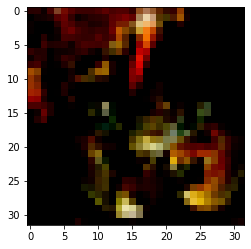

In [60]:
import matplotlib.pyplot as plt
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
show(x)

In [61]:
m = torch.nn.Softmax(dim=1)

In [62]:
for img, lbl, _ in example_test_loader:
    img = img.float().to(params.DEVICE)
    classify_preds, _ = tmp_classify(img, exemplars, ICaRL, task, trainDS, mean, classifier, clf_params)
    outputs_preds = m(ICaRL(img, features = 0).to('cpu'))

In [63]:
print(lbl, testDS.classes[lbl])

tensor([45]) lobster


In [64]:
df = pd.DataFrame(columns=['class_name', 'value'])

In [65]:
for i, el in enumerate(outputs_preds.tolist()[0]):
  df.loc[i] = [testDS.classes[i], el]

In [66]:
df.sort_values(by=['value'], ascending=False)

,class_name,value
45,lobster,4.019312e-01
74,shrew,1.747842e-01
26,crab,9.750660e-02
78,snake,5.860752e-02
88,tiger,5.476668e-02
...,...,...
68,road,2.598849e-07
53,orange,2.188605e-07
36,hamster,9.242576e-09
60,plain,5.232689e-09


In [37]:
np.argmax(outputs_preds.tolist())

20

In [38]:
classify_preds

tensor([20])